### Linear Regression on California House Prediction dataset

####  Imports

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_percentage_error

#### Basic info on the dataset

In [35]:
housing_dataset = fetch_california_housing(as_frame=True)
print(housing_dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [36]:
# the features in the dataset
print(housing_dataset.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [37]:
# the target variable that we need to predict
print(housing_dataset.target_names)

['MedHouseVal']


In [38]:
# shape of the feature matrix and the target variable
print(housing_dataset.data.shape)
print(housing_dataset.target.shape)

(20640, 8)
(20640,)


There are 20,640 samples that we have, each with 8 features. We need to use them to predict the target variable: "MedHousVal", the median house value. 

In [39]:
housing_dataset.data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [40]:
housing_dataset.target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [41]:
housing_dataset.data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


#### Common set up

We'll use `ShuffleSplit` for cross-validation with 10 splits and 20% examples set aside as test examples:

In [42]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

#### Load the dataset into variables and splitting into train and test sets

In [43]:
X, y = housing_dataset.data, housing_dataset.target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
X_train.shape, y_train.shape

((16512, 8), (16512,))

#### Linear regression (using the normal equation)

Let's try using the normal equation method to train a linear regression model.

We will set up a pipeline with two stages:
+ Feature scaling (standard scaling) to scale features.
+ Linear regression on the transformed feature matrix

We will use Mean absolute error (MAE) for testing performance.

In [62]:
lin_reg_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("lin_reg", LinearRegression())
])

lin_reg_cv_results = cross_validate(
    estimator=lin_reg_pipeline,
    X=X_train, y=y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    return_estimator=True
)

#lin_reg_cv_results

lin_reg_train_error = -1 * lin_reg_cv_results["train_score"].mean()
lin_reg_test_error = -1 * lin_reg_cv_results["test_score"].mean()

print("The Mean Absolute Error (MAE) on the train set is: {:0.5f}".format(lin_reg_train_error))
print("The Mean Absolute Error (MAE) on the test set is: {:0.5f}".format(lin_reg_test_error))

The Mean Absolute Error (MAE) on the train set is: 0.52748
The Mean Absolute Error (MAE) on the test set is: 0.53217


The errors are quite high. The model may be underfit. We can address it by adding mode features through polynomial regression.

#### Linear Regression using polynomial features

Let's try to add a step to our pipeline that applies a degree 2 polynomial transformation to our features and see if we can improve performance a little.

We set the `interaction_only` parameter to True so that only the interaction pairs (pairs of values multiplied with each other) are included. The higher order features will not be included.

In [70]:
poly_reg_pipeline = Pipeline([
    ("polynomial_transform", PolynomialFeatures(degree=2, interaction_only=True)),
    ("feature_scaling", StandardScaler()),
    ("lin_reg", LinearRegression())
])

poly_reg_cv_results = cross_validate(
    estimator=poly_reg_pipeline,
    X=X_train, y=y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    return_estimator=True
)

#poly_reg_cv_results

poly_reg_train_error = -1 * poly_reg_cv_results["train_score"].mean()
poly_reg_test_error = -1 * poly_reg_cv_results["test_score"].mean()

print("The Mean Absolute Error (MAE) on the train set is: {:0.5f}".format(poly_reg_train_error))
print("The Mean Absolute Error (MAE) on the test set is: {:0.5f}".format(poly_reg_test_error))

The Mean Absolute Error (MAE) on the train set is: 0.47692
The Mean Absolute Error (MAE) on the test set is: 0.51461


We can see that both the training and test errors went down a little after applying a polynomial transformation to our features.

We can also make a plot using the validation curve to see which value of the degree parameter can give the best results to us:

Text(0, 0.5, 'Mean Absolute Error (MAE)')

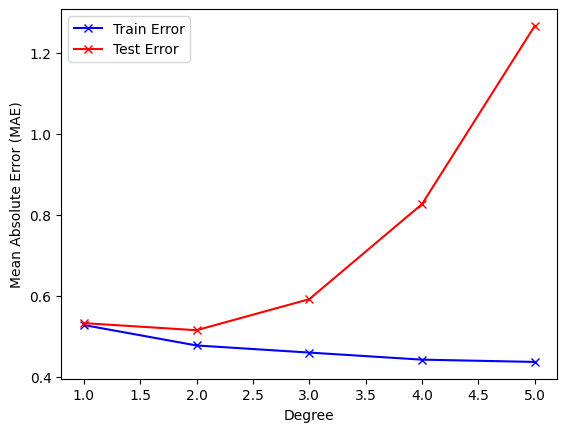

In [73]:
degree = [1, 2, 3, 4, 5]
train_scores, test_scores = validation_curve(
    estimator=poly_reg_pipeline,
    X=X_train, y=y_train,
    param_name="polynomial_transform__degree",
    param_range=degree,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

train_errors, test_errors = -train_scores.mean(axis=1), -test_scores.mean(axis=1)

plt.plot(degree, train_errors, "b-x", label="Train Error")
plt.plot(degree, test_errors, "r-x", label="Test Error")
plt.legend()

plt.xlabel("Degree")
plt.ylabel("Mean Absolute Error (MAE)")

We can see that as we increase the degree, the train error keeps going down but the test error increases dramatically using any degree greater than 2. This indicates that degree=2 is where the train and test errors are both minimized. Going past this, we'll just be overfitting on the train data and perform horribly on the testing data.

#### Linear Regression using SGD

Again, we'll first be using feature scaling and then performing regression using SGDRegressor.

We'll use the early stopping criteria to stop SGD if it doesn't converge under a certain number of iterations or if the error does not improve(and remains the same) for 5 consecutive iterations.

In [81]:
sgd_reg_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("sgd_reg", SGDRegressor(
        random_state=42,
        max_iter=55,
        early_stopping=True,
        eta0=0.0001,
        learning_rate="constant",
        tol=1e-5,
        validation_fraction=0.1,
        average=10,
        n_iter_no_change=5))])

sgd_reg_cv_results = cross_validate(
    estimator=sgd_reg_pipeline,
    X=X_train, y=y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    return_estimator=True)


sgd_reg_train_error = -1 * sgd_reg_cv_results["train_score"].mean()
sgd_reg_test_error = -1 * sgd_reg_cv_results["test_score"].mean()

print("The Mean Absolute Error (MAE) on the train set is: {:0.5f}".format(sgd_reg_train_error))
print("The Mean Absolute Error (MAE) on the test set is: {:0.5f}".format(sgd_reg_test_error))

The Mean Absolute Error (MAE) on the train set is: 0.52804
The Mean Absolute Error (MAE) on the test set is: 0.53269


#### Ridge Regression

The polynomial models have a tendency to overfit if we use higher order polynomial features. We will try using Ridge regression which penalizes excessive model complexity in the polynomial regression by adding a regularisation term. We need to specify the regularisation rate `alpha` for training the regression model. We can try using hyperparameter tuning to look for a good value of alpha that gives us the least error.

In [92]:
alpha_list = np.logspace(-4, 0, 10)
#print(alpha_list)

ridge_reg_pipeline = Pipeline([
    ("poly", PolynomialFeatures(degree=2, interaction_only=True)),
    ("feature_scaling", StandardScaler()),
    ("ridge_reg", Ridge())])

ridge_grid_search = GridSearchCV(
    estimator=ridge_reg_pipeline,
    param_grid={"ridge_reg__alpha": alpha_list},
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True)

ridge_grid_search.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(interaction_only=True)),
                                       ('feature_scaling', StandardScaler()),
                                       ('ridge_reg', Ridge())]),
             param_grid={'ridge_reg__alpha': array([1.00000000e-04, 2.78255940e-04, 7.74263683e-04, 2.15443469e-03,
       5.99484250e-03, 1.66810054e-02, 4.64158883e-02, 1.29154967e-01,
       3.59381366e-01, 1.00000000e+00])},
             return_train_score=True, scoring='neg_mean_absolute_error')

`ridge_grid_search.best_params_` gives us the best parameter found in the search.

`ridge_grid_search.best_index_` gives us the index of the best param.

In [96]:
ridge_grid_search.best_params_

{'ridge_reg__alpha': 0.046415888336127774}

In [95]:
# we want the mean error produced by the best value of alpha
mean_train_error = -1 * ridge_grid_search.cv_results_["mean_train_score"][ridge_grid_search.best_index_]
mean_test_error = -1 * ridge_grid_search.cv_results_["mean_test_score"][ridge_grid_search.best_index_]

print("The best mean absolute error (MAE) of polynomial ridge regression on the train set is: {:0.5f}".format(mean_train_error))
print("The best mean absolute error (MAE) of polynomial ridge regression on the test set is: {:0.5f}".format(mean_test_error))

The best mean absolute error (MAE) of polynomial ridge regression on the train set is: 0.47979
The best mean absolute error (MAE) of polynomial ridge regression on the test set is: 0.51198


#### Lasso Regression

Trying out lasso regression which performs a more aggressive regularisation. We'll also use hyper parameter tuning to determine an optimal value of the regularisation parameter `alpha`.

In [102]:
# the list of alphas we want to try out
alpha_list = np.logspace(-4, 0, 5)

lasso_reg_pipeline = Pipeline([
    ("poly", PolynomialFeatures(degree=2, interaction_only=True)),
    ("feature_scaling", StandardScaler()),
    ("lasso_reg", Lasso())])

lasso_grid_search = GridSearchCV(
    estimator=lasso_reg_pipeline,
    param_grid={"lasso_reg__alpha": alpha_list},
    n_jobs=-1,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True)

lasso_grid_search.fit(X_train, y_train)

/home/athena/Downloads/MLP/MLP_Code/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.814e+03, tolerance: 1.759e+00
  model = cd_fast.enet_coordinate_descent(
/home/athena/Downloads/MLP/MLP_Code/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e+03, tolerance: 1.760e+00
  model = cd_fast.enet_coordinate_descent(
/home/athena/Downloads/MLP/MLP_Code/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(interaction_only=True)),
                                       ('feature_scaling', StandardScaler()),
                                       ('lasso_reg', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso_reg__alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [104]:
lasso_grid_search.best_params_

{'lasso_reg__alpha': 0.01}

In [105]:
mean_train_error = -1 * lasso_grid_search.cv_results_["mean_train_score"][lasso_grid_search.best_index_]
mean_test_error = -1 * lasso_grid_search.cv_results_["mean_test_score"][lasso_grid_search.best_index_]

print("The best mean absolute error (MAE) of polynomial lasso regression on the train set is: {:0.5f}".format(mean_train_error))
print("The best mean absolute error (MAE) of polynomial lasso regression on the test set is: {:0.5f}".format(mean_test_error))

The best mean absolute error (MAE) of polynomial lasso regression on the train set is: 0.52501
The best mean absolute error (MAE) of polynomial lasso regression on the test set is: 0.53003


#### Performance on test set

Let's check the performance of different models on the test set.

##### Linear Regression with normal equation

In [115]:
mean_absolute_percentage_error(y_test, lin_reg_cv_results['estimator'][0].predict(X_test))

0.27272892822514455

##### Linear regression with polynomial features

In [116]:
mean_absolute_percentage_error(y_test, poly_reg_cv_results['estimator'][0].predict(X_test))

0.28384837320399975

##### Linear regression using Stochastic Gradient Descent

In [117]:
mean_absolute_percentage_error(y_test, sgd_reg_cv_results['estimator'][0].predict(X_test))

0.30945359868486205

##### Ridge regression using polynomial features and tuned value of alpha using HPT

In [118]:
mean_absolute_percentage_error(y_test, ridge_grid_search.best_estimator_.predict(X_test))

0.28469061501196724

##### Lasso regression using polynomial features and tuned value of alpha using HPT

In [119]:
mean_absolute_percentage_error(y_test, lasso_grid_search.best_estimator_.predict(X_test))

0.31803185827759184